## Applicazione analisi Detection Histories

In [1]:
#### Inserire l'anno su cui si vuole effettuare l'analisi es. =="2014", "2015", ecc
anno_analisi <- "2018"
#sessione_analisi <- "1"

In [2]:
library(dplyr)
library(readr)
library(unmarked)
require(stats4)
require(parallel)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: lattice

Loading required package: stats4


Attaching package: 'stats4'


The following object is masked from 'package:unmarked':

    mle


Loading required package: parallel



In [3]:
# Matrice di detection history (catture effettive) -- y
catture_effettive <- read.csv("Dati-preparazione-modello\\catture_effettive_totale.csv", dec=",", sep=";", header = TRUE)

# Leggiamo le matrici dell'Orario (Alba Tramonto), Precipitazioni e Temperatura -- ObsCovs
orario_occasione <- read.csv("Dati-preparazione-modello\\orario_occasione_totale.csv", dec=",", sep=";", header = TRUE, stringsAsFactors = FALSE)
precipitazioni_occasione <- read.csv("Dati-preparazione-modello\\precipitazioni_occasione_totale.csv", dec=",", sep=";", header = TRUE, stringsAsFactors = FALSE)
temperatura_occasione <- read.csv("Dati-preparazione-modello\\temperatura_occasione_totale.csv", dec=",", sep=";", header = TRUE, stringsAsFactors = FALSE)

# Prendiamo Datioccas per legare l'anno alle varie osservazioni
Datioccas <- read.csv("Dati-elaborati/Dati-occasioni.csv", dec=",", sep=";", header = TRUE)

# Leggiamo il file relativo alle invarianti ambientali (covariate) -- siteCovs
siteCovs <- read.csv("Dati-preparazione-modello/Dati-cov-mdr-iqr.csv", dec=",", sep=";", header = TRUE, stringsAsFactors = FALSE)

In [4]:
# TRASFORMIAMO le specie vegetali presenti in siteCovs in numeric
siteCovs$dominant[siteCovs$dominant != "Graminacee" & siteCovs$dominant != "Muschio"]  <- 30
siteCovs$dominant[siteCovs$dominant == "Graminacee"]  <- 20
siteCovs$dominant[siteCovs$dominant == "Muschio"]  <- 10
siteCovs$dominant <- as.numeric(siteCovs$dominant)

# Seleziono la coperatura vegetale di interesse
if (anno_analisi %in% c("2014","2015","2016","2017")) {
    siteCovs$cop_veg_ottavi <- siteCovs$Cop_Veg_2015_ottavi
    siteCovs <- subset(siteCovs, select=-c(Cop_Veg_2015_ottavi,Cop_Veg_2018_ottavi))
} else {
    siteCovs$cop_veg_ottavi <- siteCovs$Cop_Veg_2018_ottavi
    siteCovs <- subset(siteCovs, select=-c(Cop_Veg_2015_ottavi,Cop_Veg_2018_ottavi))

}
    
head(siteCovs)

,Diametro.roccia.1..cm.,Diametro.roccia.2..cm.,Diametro.roccia.3..cm.,alt_m,aspect_deg,slope_degr,n_species,dominant,MDR,IQR,Esp.tr,cop_veg_ottavi
,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>
1,59,96,102,2782.206,234,13,23,20,96,21.5,-126,5
2,176,42,76,2781.136,294,16,16,20,76,67.0,-66,2
3,51,88,62,2781.067,310,0,13,20,62,18.5,-50,2
4,99,30,36,2781.087,293,8,23,20,36,34.5,-67,5
5,164,41,47,2781.887,294,11,21,20,47,61.5,-66,2
6,130,31,36,2782.237,310,7,20,20,36,49.5,-50,4


In [5]:
# Ricaviamo le colonne oggetto di analisi
if (exists("sessione_analisi")) {
    colonne_oggetto_analisi <- rownames(subset(Datioccas,Anno == anno_analisi & sessione == sessione_analisi))
} else {
    colonne_oggetto_analisi <- rownames(subset(Datioccas,Anno == anno_analisi))
}
colonne_oggetto_analisi <- as.numeric(colonne_oggetto_analisi)

In [6]:
catture_effettive_selezionate <- catture_effettive[,colonne_oggetto_analisi]

In [7]:
summary(siteCovs)

 Diametro.roccia.1..cm. Diametro.roccia.2..cm. Diametro.roccia.3..cm.
 Min.   : 30.0          Min.   : 28.00         Min.   :  8.00        
 1st Qu.: 65.0          1st Qu.: 44.00         1st Qu.: 40.00        
 Median : 97.0          Median : 61.00         Median : 57.00        
 Mean   :113.8          Mean   : 74.61         Mean   : 78.11        
 3rd Qu.:135.0          3rd Qu.: 92.00         3rd Qu.: 82.50        
 Max.   :440.0          Max.   :308.00         Max.   :292.00        
                                                                     
     alt_m        aspect_deg      slope_degr      n_species        dominant    
 Min.   :2778   Min.   :  0.0   Min.   : 0.00   Min.   : 0.00   Min.   :10.00  
 1st Qu.:2783   1st Qu.: 36.0   1st Qu.: 8.00   1st Qu.:10.00   1st Qu.:20.00  
 Median :2789   Median :310.0   Median :12.00   Median :14.00   Median :20.00  
 Mean   :2789   Mean   :225.3   Mean   :13.27   Mean   :15.15   Mean   :20.53  
 3rd Qu.:2795   3rd Qu.:330.5   3rd Qu.:

#### Concludiamo che tutte le variabili presenti in siteCovs sono adatte ad essere utilizzate nell'analisi
#### Provvediamo a scalarle e centrarle

In [8]:
siteCovs <- data.frame(scale(siteCovs))

In [9]:
summary(t(orario_occasione[1,colonne_oggetto_analisi]))
summary(t(precipitazioni_occasione[1,colonne_oggetto_analisi]))
summary(t(temperatura_occasione[1,colonne_oggetto_analisi]))


  1     
 Al:18  
 Tr:17  

       1          
 Min.   :0.00000  
 1st Qu.:0.00000  
 Median :0.00000  
 Mean   :0.03429  
 3rd Qu.:0.00000  
 Max.   :1.00000  

       1        
 Min.   : 4.20  
 1st Qu.: 9.65  
 Median :12.60  
 Mean   :11.82  
 3rd Qu.:14.20  
 Max.   :17.40  

#### La variabile relativa alle precipitazioni, nel 2015, è inadatta alle analisi, verrà automaticamente scartata dal modello
#### Le variabili categoriche non possono essere scalate (orario_ooccasione)
#### La variabile temperatura_occasione è inadatta ad essere scalata

In [10]:
obsCovs <- list(
    orario = orario_occasione[,colonne_oggetto_analisi],
    precip = precipitazioni_occasione[,colonne_oggetto_analisi],
    temper = temperatura_occasione[,colonne_oggetto_analisi]
)


In [11]:
arvicole <- unmarkedFrameOccu(y = catture_effettive_selezionate, siteCovs = siteCovs, obsCovs = obsCovs)
summary(arvicole)

unmarkedFrame Object

75 sites
Maximum number of observations per site: 35 
Mean number of observations per site: 35 
Sites with at least one detection: 27 

Tabulation of y observations:
   0    1 
2566   59 

Site-level covariates:
 Diametro.roccia.1..cm. Diametro.roccia.2..cm. Diametro.roccia.3..cm.
 Min.   :-1.1249        Min.   :-1.0122        Min.   :-1.09284      
 1st Qu.:-0.6550        1st Qu.:-0.6648        1st Qu.:-0.59401      
 Median :-0.2254        Median :-0.2956        Median :-0.32902      
 Mean   : 0.0000        Mean   : 0.0000        Mean   : 0.00000      
 3rd Qu.: 0.2848        3rd Qu.: 0.3775        3rd Qu.: 0.06848      
 Max.   : 4.3795        Max.   : 5.0679        Max.   : 3.33421      
                                                                     
     alt_m            aspect_deg        slope_degr        n_species      
 Min.   :-1.53434   Min.   :-1.5857   Min.   :-1.5628   Min.   :-1.9922  
 1st Qu.:-0.91819   1st Qu.:-1.3323   1st Qu.:-0.6204   1s

In [39]:
fm.base <- occu(~orario+temper + MDR
            ~slope_degr + I(slope_degr^2) +
            MDR + I(MDR^2) +
            IQR + I(IQR^2) +
            Esp.tr + I(Esp.tr^2)+
            cop_veg_ottavi +
            n_species + I(n_species^2) +
            dominant,
            arvicole)
fm.base


Warning message:
"Some observations have been discarded because corresponding covariates were missing."
Warning message:
"25 sites have been discarded because of missing data."



Call:
occu(formula = ~orario + temper + MDR ~ slope_degr + I(slope_degr^2) + 
    MDR + I(MDR^2) + IQR + I(IQR^2) + Esp.tr + I(Esp.tr^2) + 
    cop_veg_ottavi + n_species + I(n_species^2) + dominant, data = arvicole)

Occupancy:
                Estimate   SE        z P(>|z|)
(Intercept)        3.736 1139  0.00328   0.997
slope_degr        -2.971  634 -0.00469   0.996
I(slope_degr^2)    3.084  547  0.00563   0.996
MDR                4.427  379  0.01170   0.991
I(MDR^2)          -0.713  218 -0.00326   0.997
IQR               15.818  624  0.02536   0.980
I(IQR^2)          -6.293  310 -0.02031   0.984
Esp.tr            -1.378  707 -0.00195   0.998
I(Esp.tr^2)        3.750  205  0.01825   0.985
cop_veg_ottavi   -30.913  672 -0.04601   0.963
n_species          2.489  379  0.00656   0.995
I(n_species^2)     9.069  316  0.02868   0.977
dominant           5.644  495  0.01141   0.991

Detection:
            Estimate     SE      z  P(>|z|)
(Intercept)  -3.4239 0.5591 -6.123 9.16e-10
orarioTr    

In [13]:
#fm.base <- occu(~orario+temper 
#            ~Diametro.roccia.1..cm.+
 #           Diametro.roccia.2..cm.+
  #          Diametro.roccia.3..cm.+
   #         cop_veg_ottavi +
    #        slope_degr + I(slope_degr^2) +
     #       n_species + I(n_species^2) +
      #      dominant,
       #     arvicole)
#fm.base

In [40]:
######### INFORMATICA
clusterType <- if(length(find.package("snow", quiet = TRUE))) "SOCK" else "PSOCK"
clusterType
clust <- try(makeCluster(getOption("cl.cores", 2), type = clusterType))
clusterEvalQ(clust, library(unmarked))
clusterEvalQ(clust,library(MuMIn))
clusterExport(clust, "arvicole")
invisible(clusterCall(clust, "library", "stats4", character.only = TRUE))
library(MuMIn)
getAllTerms(fm.base)

[1] "SOCK"

[[1]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[2]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"

[[1]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[2]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"

[1] "p(MDR)"               "p(orario)"            "p(temper)"           
 [4] "psi(cop_veg_ottavi)"  "psi(dominant)"        "psi(Esp.tr)"         
 [7] "psi(I(Esp.tr^2))"     "psi(IQR)"             "psi(I(IQR^2))"       
[10] "psi(MDR)"             "psi(I(MDR^2))"        "psi(n_species)"      
[13] "psi(I(n_species^2))"  "psi(slope_degr)"      "psi(I(slope_degr^2))"
attr(,"intercept")
  p psi 
  1   1 
attr(,"interceptLabel")
[1] "p(Int)"   "psi(Int)"
attr(,"deps")
                     p(MDR) p(orario) p(temper) psi(cop_veg_ottavi)
p(MDR)                   NA     FALSE     FALSE               FALSE
p(orario)             FALSE        NA     FALSE               FALSE
p(temper)             FALSE     FALSE        NA               FALSE
psi(cop_veg_ottavi)   FALSE     FALSE     FALSE                  NA
psi(dominant)         FALSE     FALSE     FALSE               FALSE
psi(Esp.tr)           FALSE     FALSE     FALSE               FALSE
psi(I(Esp.tr^2))      FALSE     FALSE     FALSE               FALSE
psi(IQR)              FALSE     FALSE     FALSE               FALSE
psi(I(IQR^2))         FALSE     FALSE     FALSE               FALSE
psi(MDR)              FALSE     FALSE     FALSE               FALSE
psi(I(MDR^2))         FALSE     FALSE     FALSE               FALSE
psi(n_species)        FALSE     FALSE     FALSE               FALSE
psi(I(n_species^2))   FALSE     FALSE     FALSE               FALSE
psi(slope_degr)       FALSE     FALSE     FALSE               FALSE
psi(I(slope_degr^2))  FALSE     FALSE     FALSE               FALSE
                     psi(dominant) psi(Esp.tr) psi(I(Esp.tr^2)) psi(IQR)
p(MDR)                       FALSE       FALSE            FALSE    FALSE
p(orario)                    FALSE       FALSE            FALSE    FALSE
p(temper)                    FALSE       FALSE            FALSE    FALSE
psi(cop_veg_ottavi)          FALSE       FALSE            FALSE    FALSE
psi(dominant)                   NA       FALSE            FALSE    FALSE
psi(Esp.tr)                  FALSE          NA            FALSE    FALSE
psi(I(Esp.tr^2))             FALSE       FALSE               NA    FALSE
psi(IQR)                     FALSE       FALSE            FALSE       NA
psi(I(IQR^2))                FALSE       FALSE            FALSE    FALSE
psi(MDR)                     FALSE       FALSE            FALSE    FALSE
psi(I(MDR^2))                FALSE       FALSE            FALSE    FALSE
psi(n_species)               FALSE       FALSE            FALSE    FALSE
psi(I(n_species^2))          FALSE       FALSE            FALSE    FALSE
psi(slope_degr)              FALSE       FALSE            FALSE    FALSE
psi(I(slope_degr^2))         FALSE       FALSE            FALSE    FALSE
                     psi(I(IQR^2)) psi(MDR) psi(I(MDR^2)) psi(n_species)
p(MDR)                       FALSE    FALSE         FALSE          FALSE
p(orario)                    FALSE    FALSE         FALSE          FALSE
p(temper)                    FALSE    FALSE         FALSE          FALSE
psi(cop_veg_ottavi)          FALSE    FALSE         FALSE          FALSE
psi(dominant)                FALSE    FALSE         FALSE          FALSE
psi(Esp.tr)                  FALSE    FALSE         FALSE          FALSE
psi(I(Esp.tr^2))             FALSE    FALSE         FALSE          FALSE
psi(IQR)                     FALSE    FALSE         FALSE          FALSE
psi(I(IQR^2))                   NA    FALSE         FALSE          FALSE
psi(MDR)                     FALSE       NA         FALSE          FALSE
psi(I(MDR^2))                FALSE    FALSE            NA          FALSE
psi(n_species)               FALSE    FALSE         FALSE             NA
psi(I(n_species^2))          FALSE    FALSE         FALSE          FALSE
psi(slope_degr)              FALSE    FALSE         FALSE          FALSE
psi(I(slope_degr^2))         FALSE    FALSE         FALSE          FALSE
                     psi(I(n_species^2)) psi(slope_degr) psi(I(slope_degr^2))
p(MDR)                      

In [15]:
#pdd2 <- pdredge(fm.base, clust,
#                subset = (`psi(slope_degr)` | !`psi(I(slope_degr^2))`) &&
#                 (`psi(n_species)` | !`psi(I(n_species^2))`) &&
#                 `psi(dominant)`,               
#                trace = 2, m.lim = c(1,NA))

In [16]:
#save(pdd2, file="Dati-elaborati/pdd2.RData", compress=FALSE)
#load("Dati-elaborati/pdd2.RData")

In [41]:
pdd3 <- pdredge(fm.base, clust,
                subset = (`psi(slope_degr)` | !`psi(I(slope_degr^2))`) &&
                (`psi(n_species)` | ! `psi(I(n_species^2))`) &&
                (`psi(MDR)` | ! `psi(I(MDR^2))`)&&
                (`psi(IQR)` | ! `psi(I(IQR^2))`)&&
                (`psi(Esp.tr)` | ! `psi(I(Esp.tr^2))`)&&
                 `psi(cop_veg_ottavi)` &&
                # `p(MDR)` &&
                 `p(temper)` &&
                 `p(orario)` &&
                 `psi(dominant)`,
                trace = 2, m.lim = c(1,NA))
save(pdd3, file="Dati-elaborati/pdd3.RData", compress=FALSE)
load("Dati-elaborati/pdd3.RData")

Fixed terms are "p(Int)" and "psi(Int)"



  |======================================================================| 100%


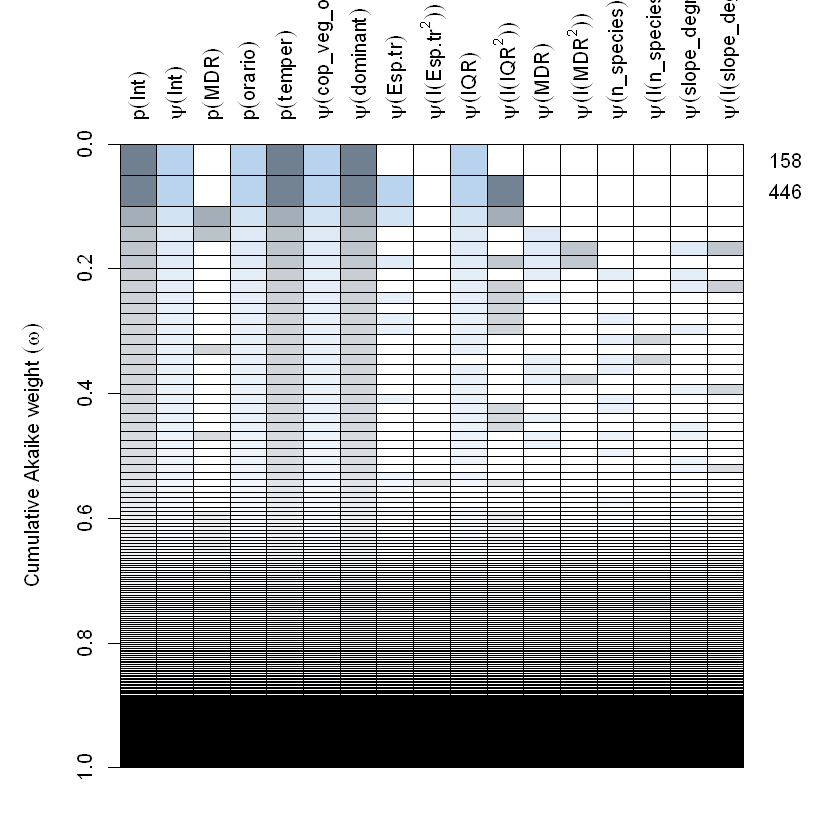

In [42]:
par(mfrow = c(1,1))
op <- par(mar = c(3,5,6,4), mfrow=c(1,1))
plot(pdd3, labAsExpr = TRUE)
par(op)


In [55]:
# riportare la tabella dei coefficienti
summary(get.models(pdd3, 1)[[1]])

Warning message:
"Some observations have been discarded because corresponding covariates were missing."
Warning message:
"25 sites have been discarded because of missing data."



Call:
occu(formula = ~orario + temper + 1 ~ cop_veg_ottavi + dominant + 
    IQR + 1, data = arvicole)

Occupancy (logit-scale):
               Estimate   SE      z P(>|z|)
(Intercept)        27.3 28.5  0.956   0.339
cop_veg_ottavi    -37.2 36.5 -1.019   0.308
dominant           15.2 32.2  0.471   0.638
IQR                21.6 24.7  0.874   0.382

Detection (logit-scale):
            Estimate     SE      z  P(>|z|)
(Intercept)  -3.4770 0.5585 -6.226 4.80e-10
orarioTr      0.4059 0.2736  1.484 1.38e-01
temper        0.0209 0.0414  0.506 6.13e-01

AIC: 488.2789 
Number of sites: 50
ID of sites removed due to NA: 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
optim convergence code: 0
optim iterations: 101 
Bootstrap iterations: 0 



In [56]:
## PASSAGGIO DI MODEL AVERAGING: CONSIDERIAMO CONTEMPORANEAMENTE I MODELLI MIGLIORI CHE DIFFERISCONO TRA LORO
## DI POCO IN TERMINI DI AIC (deltaAIC < 2)
summary(model.avg(pdd3, subset = delta < 2))


Call:
model.avg(object = pdd3, subset = delta < 2)

Component model call: 
occu(formula = ~<7 unique rhs>, data = arvicole)

Component models: 
                     df  logLik   AICc delta weight
2/3/4/5/7             7 -237.14 490.95  0.00   0.23
2/3/4/5/6/7/8         9 -234.25 491.01  0.06   0.22
1/2/3/4/5/6/7/8      10 -233.11 491.86  0.92   0.15
1/2/3/4/5/7/9         9 -234.97 492.45  1.50   0.11
2/3/4/5/7/9/10/12/13 11 -231.82 492.58  1.63   0.10
2/3/4/5/6/7/8/9/10   11 -231.84 492.62  1.68   0.10
2/3/4/5/7/9/11/12    10 -233.61 492.86  1.91   0.09

Term codes: 
              p(MDR)            p(orario)            p(temper) 
                   1                    2                    3 
 psi(cop_veg_ottavi)        psi(dominant)          psi(Esp.tr) 
                   4                    5                    6 
            psi(IQR)        psi(I(IQR^2))             psi(MDR) 
                   7                    8                    9 
       psi(I(MDR^2))       psi(n_species)

In [63]:
best.mod1 <- (get.models(pdd3, 1)[[1]])
best.mod1

Warning message:
"Some observations have been discarded because corresponding covariates were missing."
Warning message:
"25 sites have been discarded because of missing data."



Call:
occu(formula = ~orario + temper + 1 ~ cop_veg_ottavi + dominant + 
    IQR + 1, data = arvicole)

Occupancy:
               Estimate   SE      z P(>|z|)
(Intercept)        27.3 28.5  0.956   0.339
cop_veg_ottavi    -37.2 36.5 -1.019   0.308
dominant           15.2 32.2  0.471   0.638
IQR                21.6 24.7  0.874   0.382

Detection:
            Estimate     SE      z  P(>|z|)
(Intercept)  -3.4770 0.5585 -6.226 4.80e-10
orarioTr      0.4059 0.2736  1.484 1.38e-01
temper        0.0209 0.0414  0.506 6.13e-01

AIC: 488.2789 

In [64]:
best.mod <- occu(~ MDR + temper
                 ~ MDR +
                   Esp.tr +
                   dominant,
                 arvicole)
best.mod


Call:
occu(formula = ~MDR + temper ~ MDR + Esp.tr + dominant, data = arvicole)

Occupancy:
            Estimate    SE      z P(>|z|)
(Intercept)   -0.256 0.313 -0.816   0.415
MDR            0.713 0.472  1.512   0.130
Esp.tr        -0.353 0.335 -1.055   0.291
dominant       0.113 0.291  0.387   0.699

Detection:
            Estimate     SE      z  P(>|z|)
(Intercept)  -3.0017 0.5129 -5.853 4.83e-09
MDR          -0.1625 0.1505 -1.079 2.80e-01
temper        0.0107 0.0407  0.263 7.92e-01

AIC: 542.6953 

In [65]:
newdat1 <- data.frame(MDR = mean(siteCovs$MDR),
                     Esp.tr = seq(min(siteCovs$Esp.tr), max(siteCovs$Esp.tr), length=100),
                     dominant = "Graminacee")
newdat2 <- data.frame(MDR = mean(siteCovs$MDR),
                      Esp.tr = seq(min(siteCovs$Esp.tr), max(siteCovs$Esp.tr),length=100),
                      dominant = "Muschio")
newdat3 <- data.frame(MDR = mean(siteCovs$MDR),
                      Esp.tr = seq(min(siteCovs$Esp.tr), max(siteCovs$Esp.tr),length=100),
                      dominant = "Other_sp")
newdat <- rbind(newdat1,newdat2,newdat3)

In [68]:
Elambda <- predict(best.mod, type='state', newdata=newdat,
                   appendData=TRUE)
head(Elambda)
Elambda.logit <- Elambda


ERROR: Error in .local(obj, coefficients, ...): ncol(coefficients) == length(obj@estimates) is not TRUE


In [49]:

par(mfrow=c(1, 2))

with(subset(Elambda.logit,dominant=="Graminacee"), {
  plot(Esp.tr, Predicted, xlab="Esposizione", type="l", # names = habitat,
       ylab="Probabilità di presenza", #ylim=c(-20, 40), # cex.names=0.7,
       cex.lab=0.7, cex.axis=0.7, lwd=2, col="red")
   lines(Esp.tr, upper, lty=2, col="grey")
  lines(Esp.tr, lower, lty=2, col="grey")
})

ERROR: Error in .local(obj, coefficients, ...): ncol(coefficients) == length(obj@estimates) is not TRUE


In [44]:
best.mod <- (get.models(pdd2, 1)[[1]])
best.mod <- occu(~ MDR + temp
                 ~ MDR +
                   Esp.tr +
                   dominante,
                 blgr)
# ?unmarkedFitOccu-class

# Predict abundance at specified covariate values.
newdat1 <- data.frame(MDR = mean(sc.def$MDR),
                     Esp.tr = seq(min(sc.def$Esp.tr), max(sc.def$Esp.tr), length=100),
                     dominante = "Graminacee")
newdat2 <- data.frame(MDR = mean(sc.def$MDR),
                      Esp.tr = seq(min(sc.def$Esp.tr), max(sc.def$Esp.tr), length=100),
                      dominante = "Muschio")
newdat3 <- data.frame(MDR = mean(sc.def$MDR),
                      Esp.tr = seq(min(sc.def$Esp.tr), max(sc.def$Esp.tr), length=100),
                      dominante = "Other_sp")
newdat <- rbind(newdat1,newdat2,newdat3)
Elambda <- predict(best.mod, type='state', newdata=newdat,
                   appendData=TRUE)
head(Elambda)
Elambda.logit <- Elambda
# Elambda.logit$Predicted <- log(Elambda.logit$Predicted/(1-Elambda.logit$Predicted))
# Elambda.logit$SE <- log(Elambda.logit$SE/(1-Elambda.logit$SE))
# Elambda.logit$lower <- log(Elambda.logit$lower/(1-Elambda.logit$lower))
# Elambda.logit$upper <- log(Elambda.logit$upper/(1-Elambda.logit$upper))
# with(Elambda, log(Predicted)-log(1-Predicted))
par(mfrow=c(1, 2))
# with(Elambda, {
#   plot(Esp.tr, log(Predicted)-log(1-Predicted), xlab="Esposizione", type="l", # names = habitat,
#                ylab="Occupancy", #ylim=c(-20, 40), # cex.names=0.7,
#                cex.lab=0.7, cex.axis=0.7, lwd=2, col="red")
#   lines(Esp.tr, log(Predicted)-log(1-Predicted)+log(SE/1-SE), lty=3, col="grey")
#   lines(Esp.tr, log(Predicted)-log(1-Predicted)-log(SE/1-SE), lty=2, col="grey")
# })
with(subset(Elambda.logit,dominante=="Graminacee"), {
  plot(Esp.tr, Predicted, xlab="Esposizione", type="l", # names = habitat,
       ylab="Probabilità di presenza", #ylim=c(-20, 40), # cex.names=0.7,
       cex.lab=0.7, cex.axis=0.7, lwd=2, col="red")
  # lines(Esp.tr, Predicted+SE, lty=3, col="dark grey")
  # lines(Esp.tr, Predicted-SE, lty=3, col="dark grey")
  lines(Esp.tr, upper, lty=2, col="grey")
  lines(Esp.tr, lower, lty=2, col="grey")
})
# with(subset(Elambda.logit,dominante=="Graminacee"), {
#   plot(Esp.tr, Predicted, xlab="Esposizione", type="l", # names = habitat,
#        ylab="Probabilità di presenza", #ylim=c(-20, 40), # cex.names=0.7,
#        cex.lab=0.7, cex.axis=0.7, lwd=2, col="red")
#   lines(Esp.tr, Predicted+SE, lty=3, col="dark grey")
#   lines(Esp.tr, Predicted-SE, lty=3, col="dark grey")
#   # lines(Esp.tr, upper, lty=2, col="grey")
#   # lines(Esp.tr, lower, lty=2, col="grey")
# })
# Predict abundance at specified covariate values.
newdat1 <- data.frame(MDR = seq(min(sc.def$MDR), max(sc.def$MDR), length=100),
                      Esp.tr = mean(sc.def$Esp.tr),
                      dominante = "Graminacee")
newdat2 <- data.frame(MDR = seq(min(sc.def$MDR), max(sc.def$MDR), length=100),
                      Esp.tr = mean(sc.def$Esp.tr),
                      dominante = "Muschio")
newdat3 <- data.frame(MDR = seq(min(sc.def$MDR), max(sc.def$MDR), length=100),
                      Esp.tr = mean(sc.def$Esp.tr),
                      dominante = "Other_sp")
newdat <- rbind(newdat1,newdat2,newdat3)
Elambda <- predict(best.mod, type='state', newdata=newdat,
                   appendData=TRUE)
head(Elambda)
Elambda.logit <- Elambda
with(subset(Elambda.logit,dominante=="Graminacee"), {
  plot(MDR, Predicted, xlab="MDR", type="l", # names = habitat,
       ylab="Probabilità di presenza", #ylim=c(-20, 40), # cex.names=0.7,
       cex.lab=0.7, cex.axis=0.7, lwd=2, col="red")
  # lines(MDR, Predicted+SE, lty=3, col="dark grey")
  # lines(MDR, Predicted-SE, lty=3, col="dark grey")
  lines(MDR, upper, lty=2, col="grey")
  lines(MDR, lower, lty=2, col="grey")
})


newdat1 <- data.frame(MDR = seq(min(sc.def$MDR), max(sc.def$MDR), length=100),
                      temp = 13.14)
Elambda.det <- predict(best.mod, type='det', newdata=newdat1,
                   appendData=TRUE)
with(Elambda.det, {
  plot(MDR, Predicted, xlab="MDR", type="l", # names = habitat,
       ylab="Probabilità di cattura", #ylim=c(-20, 40), # cex.names=0.7,
       cex.lab=0.7, cex.axis=0.7, lwd=2, col="red")
  # lines(MDR, Predicted+SE, lty=3, col="dark grey")
  # lines(MDR, Predicted-SE, lty=3, col="dark grey")
  lines(MDR, upper, lty=2, col="grey")
  lines(MDR, lower, lty=2, col="grey")
})
newdat1 <- data.frame(MDR = mean(sc.def$MDR),
                      temp = seq(7.99, 17.95, length=100))
Elambda.det <- predict(best.mod, type='det', newdata=newdat1,
                       appendData=TRUE)
with(Elambda.det, {
  plot(temp, Predicted, xlab="temperatura", type="l", # names = habitat,
       ylab="Probabilità di cattura", #ylim=c(-20, 40), # cex.names=0.7,
       cex.lab=0.7, cex.axis=0.7, lwd=2, col="red")
  # lines(temp, Predicted+SE, lty=3, col="dark grey")
  # lines(temp, Predicted-SE, lty=3, col="dark grey")
  lines(temp, upper, lty=2, col="grey")
  lines(temp, lower, lty=2, col="grey")
})


ERROR: Error in nrow(y): oggetto "y" non trovato
